In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import os
import datetime
import numpy as np


In [ ]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/leela/test3/AlphaZero_Chess/src")

from policy_index import policy_index

action_size = len(policy_index)
num_resblock = 4

In [ ]:
os.chdir("/content/")


In [ ]:
from torch.nn import MSELoss

In [ ]:
# get data from Oscar, might need to rewrite to fit the data structure he has
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

numpy_data = np.random.randn(100,112, 8, 8) # 10 samples, image size = 224 x 224 x 3
numpy_target = np.random.randint(0,5,size=(100))

dataset = MyDataset(numpy_data, numpy_target)
loader = DataLoader(dataset, batch_size=5, shuffle=True, num_workers=2, pin_memory=False)  # Running on CPU

In [ ]:
# convblock for doing convolutional work
class ConvBlock(nn.Module):
    def __init__(self):
        super(ConvBlock, self).__init__()
        self.action_size = action_size
        self.conv1 = nn.Conv2d(112, 256, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(256)

    def forward(self, s):
        s = s.view(-1, 112, 8, 8)  # batch_size x channels x board_x x board_y
        s = F.relu(self.bn1(self.conv1(s)))
        return s


# Resblock to do residual block: x + conv output (x)
class ResBlock(nn.Module):
    def __init__(self, inplanes=256, planes=256, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = F.relu(out)
        return out


# final FC layers
# get more layer in the last round + flatten
class OutBlock(nn.Module):
    def __init__(self):
        super(OutBlock, self).__init__()
        self.conv = nn.Conv2d(256, 1, kernel_size=1) # value head
        self.bn = nn.BatchNorm2d(1)
        self.fc1 = nn.Linear(8*8, 64)
        self.fc2 = nn.Linear(64, 1)
        
        # self.conv1 = nn.Conv2d(256, 128, kernel_size=1) # policy head
        # self.bn1 = nn.BatchNorm2d(128)
        # self.logsoftmax = nn.LogSoftmax(dim=1)
        # self.fc = nn.Linear(8*8*128, 8*8*73)
    
    def forward(self,s):
        v = F.relu(self.bn(self.conv(s))) # value head
        v = v.view(-1, 8*8)  # batch_size X channel X height X width
        v = F.relu(self.fc1(v))
        v = F.relu(self.fc2(v))
        
        # p = F.relu(self.bn1(self.conv1(s))) # policy head
        # p = p.view(-1, 8*8*128)
        # p = self.fc(p)
        # p = self.logsoftmax(p).exp()
        return v
    
# stacking conv block + a bunch of res block + out block
class ChessNet(nn.Module):
    def __init__(self):
        super(ChessNet, self).__init__()
        self.conv = ConvBlock()
        for block in range(num_resblock):
            setattr(self, "res_%i" % block,ResBlock())
        self.outblock = OutBlock()
    
    def forward(self,s):
        s = self.conv(s)
        for block in range(num_resblock):
            s = getattr(self, "res_%i" % block)(s)
        s = self.outblock(s)
        return s
        
    
# training
def train(net, dataset, epoch_start=0, epoch_stop=20, cpu=0):
    torch.manual_seed(cpu)
    cuda = torch.cuda.is_available()
    net.train()
    criterion = MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.003)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400], gamma=0.2)
    
    # train_set = board_data(dataset)
    # train_loader = DataLoader(train_set, batch_size=30, shuffle=True, num_workers=0, pin_memory=False)
    train_loader = dataset
    losses_per_epoch = []
    for epoch in range(epoch_start, epoch_stop):
        scheduler.step()
        total_loss = 0.0
        losses_per_batch = []
        for i,data in enumerate(train_loader,0):
            state, value = data
            if cuda:
                state, value = state.cuda().float(), value.cuda().float()
            optimizer.zero_grad()
            value_pred = net(state) # policy_pred = torch.Size([batch, 4672]) value_pred = torch.Size([batch, 1])
            # print(value_pred, value)
            # print(value_pred.shape, value.shape)
            loss = criterion(value_pred[:,0], value)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            losses_per_batch.append(loss.item())
        try:
          losses_per_epoch.append(np.mean(losses_per_batch))
        except:
          losses_per_epoch.append(0.1)
        if len(losses_per_epoch) > 100:
            if abs(sum(losses_per_epoch[-4:-1])/3-sum(losses_per_epoch[-16:-13])/3) <= 0.01:
                break

    plt.figure(figsize=(12,8))
    # ax = fig.add_subplot(222)
    plt.scatter([e for e in range(1,epoch_stop+1,1)], losses_per_epoch)
    plt.xlabel("Epoch")
    plt.ylabel("Loss per batch")
    plt.title("Loss vs Epoch")
    print('Finished Training')
    plt.savefig(os.path.join("./", "Loss_vs_Epoch_%s.png" % datetime.datetime.today().strftime("%Y-%m-%d")))

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Finished Training


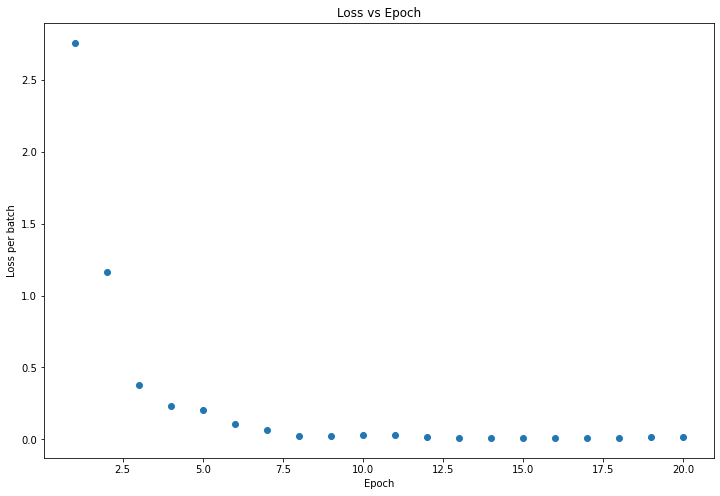

In [ ]:
# from alpha_net import ChessNet, train
import os
import pickle
import numpy as np
import torch

def train_chessnet(net_to_train= None ,save_as= "weights.pth.tar"):
    # gather data
    # data_path = "./datasets/iter1/"
    # datasets = []
    # for idx,file in enumerate(os.listdir(data_path)):
    #     filename = os.path.join(data_path,file)
    #     with open(filename, 'rb') as fo:
    #         datasets.extend(pickle.load(fo, encoding='bytes'))
    
    # data_path = "./datasets/iter0/"
    # for idx,file in enumerate(os.listdir(data_path)):
    #     filename = os.path.join(data_path,file)
    #     with open(filename, 'rb') as fo:
    #         datasets.extend(pickle.load(fo, encoding='bytes'))
    
    # datasets = np.array(datasets)
    
    # train net

    datasets = loader
    net = ChessNet()
    cuda = torch.cuda.is_available()
    if cuda:
        net.cuda()

    if net_to_train:
        current_net_filename = os.path.join("./model_data/",\
                                        net_to_train)
        checkpoint = torch.load(current_net_filename)
        net.load_state_dict(checkpoint['state_dict'])

    train(net,datasets)
    # save results
    # torch.save({'state_dict': net.state_dict()}, os.path.join("./model/",\
    #                                 save_as))

if __name__=="__main__":
    train_chessnet()